### Please keep in mind this is an initial, naive solution and is subject to drastic change.

In [1]:
from pathlib import Path
from anomalib.data.utils import read_image
from anomalib.deploy import TorchInferencer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from anomalib.data.folder import Folder

/home/sonofman/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Additionally I modified the our data in the following way:
- I moved all the normal and abnomral instances into their own directories all together,
- I also removed any images with \*ref|Ref\* in their name that were in the abnormal/anomalous directories from being since they are from the refrence image, meaning they are what the client wants. You can verify this for yourselfes.
- To start you might also want to remove the images that are masked initially if you are only running this file, expect updates soon...

In [2]:
from anomalib.data.task_type import TaskType

cwd = Path.cwd()
parent_dir = cwd.parent

data_module = Folder(
    root=parent_dir / "Reels",
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.1,
    image_size=(256, 256),
    train_batch_size=32,
    eval_batch_size=32,
    task=TaskType.CLASSIFICATION,
)
data_module.setup()
data_module.prepare_data()
i, data = next(enumerate(data_module.val_dataloader()))
print(data.keys())

/home/sonofman/anomalib/src/anomalib/data/folder.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  samples.loc[(samples.label == DirType.NORMAL), "split"] = Split.TRAIN
/home/sonofman/anomalib/src/anomalib/data/folder.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'train' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  samples.loc[(samples.label == DirType.NORMAL), "split"] = Split.TRAIN


dict_keys(['image_path', 'label', 'image'])


In [4]:
print(data["image"].shape)

torch.Size([32, 3, 256, 256])


In [3]:
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

/home/sonofman/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [6]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC"],
    ),
    ModelCheckpoint(
        every_n_epochs=4,
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(256, 256),
        dirpath=str(Path.cwd()),
        filename="model",
        export_mode=ExportMode.TORCH,
    ),
]

In [5]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    auto_scale_batch_size=False,
    check_val_every_n_epoch=4,
    devices=1,
    gpus=None,
    max_epochs=20,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)
trainer.fit(model=model, datamodule=data_module)

NameError: name 'callbacks' is not defined

In [4]:
test_results = trainer.test(model=model, datamodule=data_module)

NameError: name 'trainer' is not defined

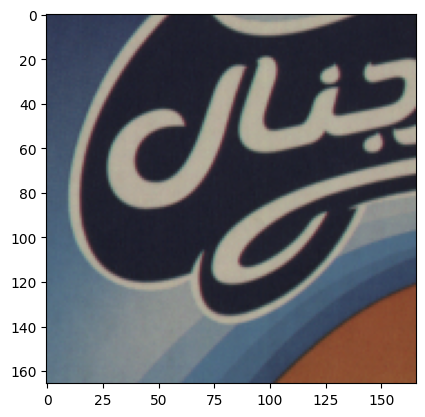

In [17]:
from matplotlib import pyplot as plt
imagepath = parent_dir / "Reels/normal/NRefSpot121.bmp"
image = read_image(imagepath)
plt.imshow(image)

In [29]:
abnormal_imagepath = parent_dir / "Reels/abnormal/YSpot48.bmp"
abnormal_image = read_image(abnormal_imagepath)
# plt.imshow(abnormal_imagepath)

In [24]:
print(Path.cwd())
mode_path = Path.cwd() / 'weights/torch/model.pt'
inferencer = TorchInferencer(path=mode_path)

/home/sonofman/edgehackathon/Hackathon/juice_boy🧃


In [25]:
print(image.shape)
predictions = inferencer.predict(image=image)
# type(predictions)
# predictions
predictions2 = inferencer.predict(image=abnormal_image)

(166, 166, 3)


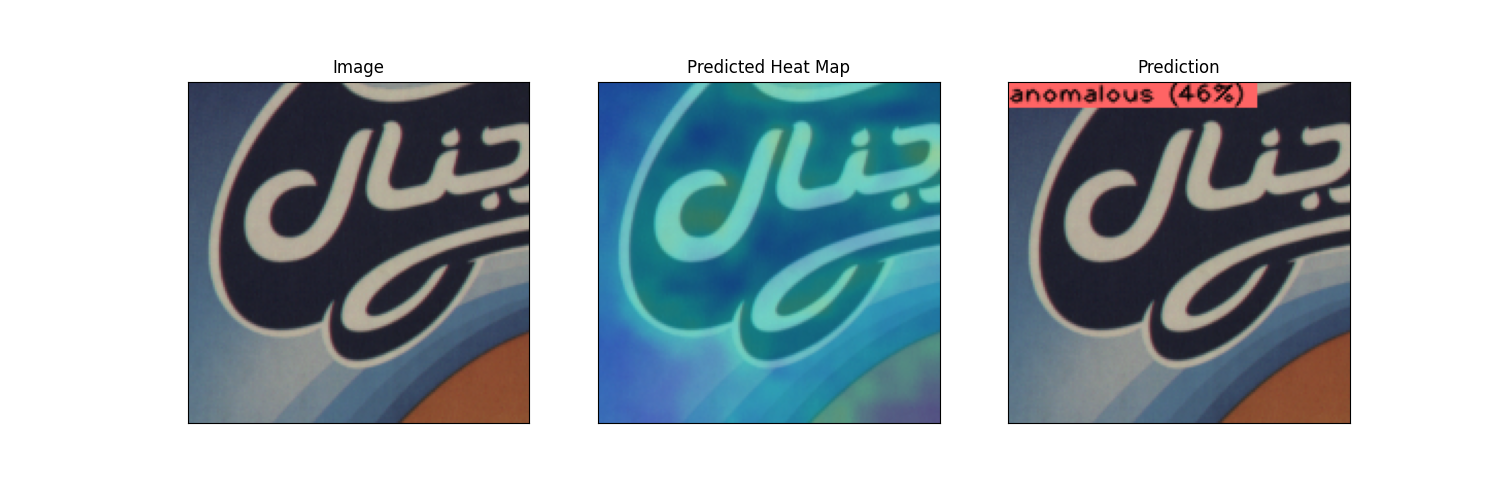

In [27]:
from anomalib.post_processing import Visualizer, VisualizationMode
from PIL import Image

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions)
Image.fromarray(output_image)

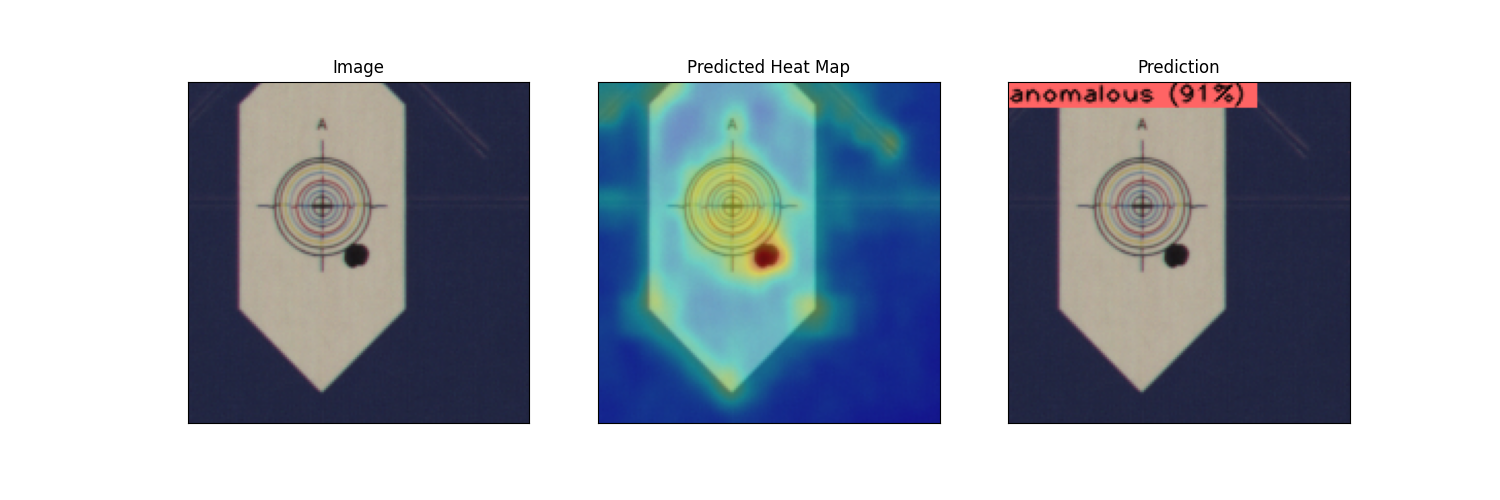

In [28]:
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(predictions2)
Image.fromarray(output_image)